In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ipynb.fs.full.orfHMM_EM import EM_iter
from ipynb.fs.full.orfHMM_Viterbi import viterbi_sequence

# Simulation Data

In [2]:
def generate_nb(state):
    '''
    Given the state, generate the NB distribution
    state: int
    '''
    return np.random.negative_binomial(alpha_list_true[state-1], beta_list_true[state-1]/(1+beta_list_true[state-1]))

In [3]:
def simulate_1_11(curr_RNA, curr_observed, state_list, count, curr_state):
    '''
    Simulate for untranslated region
    '''
    # check if AUG would occur
    start = random.choices([True, False], weights=np.ones(2), k = 1)[0]    
    while start == False:      
        
        # if no, generate single base
        curr_RNA += random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 1)[0]
        curr_observed.append(generate_nb(curr_state))
        state_list.append(curr_state)
        count += 1
        start = random.choices([True, False], weights=np.ones(2), k = 1)[0] # check if AUG occurs
        
        # if last three element is 'AUG', remove the current RNA, observed data
        if "".join(curr_RNA[-3:]) == 'AUG':
            curr_RNA = curr_RNA[:-3]
            curr_observed = curr_observed[:-3]
            state_list = state_list[:-3]
            count -= 3
            start = True
        
        if count >= 100:
            return (curr_RNA, curr_observed, state_list, count)
    
    return (curr_RNA, curr_observed, state_list, count)

In [4]:
def simulate():
    '''
    Simulate one single RNA sequence
    '''
    
    # count occurances
    state_1_2 = 0
    state_1_12 = 0
    state_11_12 = 0
    change_position = 0
    
    # Assume three start codons
    state_list = []
    
    # first five without start codons
    curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5)
    while 'AUG' in "".join(curr_RNA):
        curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5)
    curr_observed = [generate_nb(1), generate_nb(1), generate_nb(1), generate_nb(1), generate_nb(1)]
    state_list = [1, 1, 1, 1, 1]
    count = 5
    state = 1

    # if in state 1
    while state == 1:
        curr_RNA, curr_observed, state_list, count = simulate_1_11(curr_RNA, curr_observed, state_list, count, 1)
            
        if count >= 100:
            return (curr_RNA, curr_observed, [state_1_2, state_1_12, state_11_12], change_position, state_list)
        
        curr_RNA += ['A', 'U', 'G']
        count += 3
        state = random.choices([1, 2, 12], weights=[0.2, 0.5, 0.3], k = 1)[0]
        
        if state == 1:
            curr_observed += [generate_nb(1), generate_nb(1), generate_nb(1)] # NB for AUG
            state_list += [1, 1, 1]
        
        
    if state == 12:
        state_1_12 = 1     
          
    # if in state 2
    if state == 2:
        state_1_2 = 1  
        
        # uORF
        curr_observed += [generate_nb(2), generate_nb(3), generate_nb(4)]
        state_list += [2, 3, 4]
    
        repeat = random.choices(np.arange(20, 31), weights=np.ones(11), k = 1)[0]
        for i in range(repeat-2):
            curr_RNA += random.choices([['A', 'U', 'G'], ['G', 'U', 'U'], ['U', 'U', 'U']], weights=[0.5, 0.25, 0.25], k = 1)[0]
            curr_observed += [generate_nb(5), generate_nb(6), generate_nb(7)]
            state_list += [5, 6, 7]
            count += 3
        curr_RNA += random.choices([['U', 'A', 'A'], ['U', 'G', 'A'], ['U', 'A', 'G']], weights=[1, 1, 1], k = 1)[0]
        curr_observed += [generate_nb(8), generate_nb(9), generate_nb(10)]
        state_list += [8, 9, 10]
        count += 3
        
        # UTR
        temp = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5)
        while 'AUG' in "".join(temp):
            temp = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5) 
        curr_RNA += temp
        curr_observed += [generate_nb(11), generate_nb(11), generate_nb(11), generate_nb(11), generate_nb(11)]
        state_list += [11, 11, 11, 11, 11]
        count += 5
        change_position = len(curr_RNA)   
        state = 11  
        

        while state == 11:
            curr_RNA, curr_observed, state_list, count= simulate_1_11(curr_RNA, curr_observed, state_list, count, 11)
            
            if count >= 100:
                return (curr_RNA, curr_observed, [state_1_2, state_1_12, state_11_12], change_position, state_list)
            
            curr_RNA += ['A', 'U', 'G']
            count += 3
            state = random.choices([11, 12], weights=[0.2, 0.8], k = 1)[0]

            if state == 11:
                curr_observed += [generate_nb(11), generate_nb(11), generate_nb(11)]
                state_list += [11, 11, 11]
            elif state == 12:
                state_11_12 = 1  
                        
    # main ORF
    if state == 12:
        curr_observed += [generate_nb(12), generate_nb(13), generate_nb(14)]
        state_list += [12, 13, 14]
        repeat = random.choices(np.arange(30, 51), weights=np.ones(21), k = 1)[0]
        for i in range(repeat-2):
            curr_RNA += random.choices([['A', 'U', 'G'], ['G', 'U', 'U'], ['U', 'U', 'U']], weights=[0.5, 0.25, 0.25], k = 1)[0]
            curr_observed += [generate_nb(15), generate_nb(16), generate_nb(17)]
            state_list += [15, 16, 17]
            count += 3
        curr_RNA += random.choices([['U', 'A', 'A'], ['U', 'G', 'A'], ['U', 'A', 'G']], weights=[1, 1, 1], k = 1)[0]
        curr_observed += [generate_nb(18), generate_nb(19), generate_nb(20)]
        state_list += [18, 19, 20]
        count += 3

    
        repeat = random.choices(np.arange(20, 31), weights=np.ones(11), k = 1)[0]
        for i in range(repeat-2):
            curr_RNA += random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 1)[0]
            curr_observed.append(generate_nb(21))
            state_list.append(21)
            count += 1

      
    return (curr_RNA, curr_observed, [state_1_2, state_1_12, state_11_12], change_position, state_list)

In [5]:
def simulate_sequences(length):
    '''
    uORF + main ORF + both
    ''' 
    count_list = [0, 0 ,0]
    RNA_data = []
    observed_data = []
    count_state = 0
    state_list_true = []
    for i in range(length):
        temp = simulate()
        
        count_list[0] += temp[2][0]
        count_list[1] += temp[2][1]
        count_list[2] += temp[2][2]
        change_position = temp[3]
        state_list = temp[4]
        
        # change to only main ORF
        if temp[2][0] == 1 and temp[2][2] == 1:
            curr_observed = []
            state_list = []
            count_state += 1
            if count_state == 3:
                count_state = 0
                repeat = random.choices(np.arange(40, 81), weights=np.ones(41), k = 1)[0]
                curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = repeat)
                for i in range(repeat):
                    curr_observed.append(generate_nb(11))
                    state_list.append(11)
                while 'AUG' in "".join(curr_RNA):
                    get_index = ("".join(curr_RNA)).index('AUG')
                    curr_RNA[get_index] = random.choices(['C', 'G', 'U'], weights=np.ones(3), k = 1)[0]
                temp[0][change_position:] = curr_RNA
                temp[1][change_position:] = curr_observed
                temp[4][change_position:] = state_list
                count_list[2] -= temp[2][2]
               
        RNA_data.append(temp[0])
        observed_data.append(temp[1])
        state_list_true.append(temp[4])
    
    return (RNA_data, observed_data, count_list, state_list_true)

In [6]:
def simulate_neither(length):
    '''
    Untranslated region
    '''
    RNA_data = []
    observed_data = []
    state_list_true = []
    for num in range(length):
        curr_observed = []
        curr_state = []
        repeat = random.choices(np.arange(40, 81), weights=np.ones(41), k = 1)[0]
        curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = repeat)
        for i in range(repeat):
            curr_observed.append(generate_nb(1))
            curr_state.append(1)
        while 'AUG' in "".join(curr_RNA):
            get_index = ("".join(curr_RNA)).index('AUG')
            curr_RNA[get_index] = random.choices(['C', 'G', 'U'], weights=np.ones(3), k = 1)[0]
        RNA_data.append(curr_RNA)
        observed_data.append(curr_observed)
        state_list_true.append(curr_state)
    return (RNA_data, observed_data, state_list_true)

# Generate Data

In [7]:
# Give values
mean_list_true = np.array([80, 350, 300, 250, 200, 150, 120, 320, 250, 220, 80, 450, 400, 300, 250, 230, 100, 430, 350, 320, 80]) # mean
variance_list_true = mean_list_true*1.2 
beta_list_true = 1/(variance_list_true/mean_list_true-1)
alpha_list_true = mean_list_true * beta_list_true

# Simulate
random.seed(0)
part1 = simulate_sequences(2700) 
part2 = simulate_neither(300)  
RNA_data = part1[0] + part2[0]
observed_data = part1[1] + part2[1]
state_list_true = part1[3] + part2[2]

# shuffle data
c = list(zip(RNA_data, observed_data, state_list_true))
random.shuffle(c)
RNA_data, observed_data, state_list_true = zip(*c)

In [8]:
E = list(np.repeat(1, 3000)) 
stop_codon_list = ['UAA', 'UGA', 'UAG']

# Data Plots

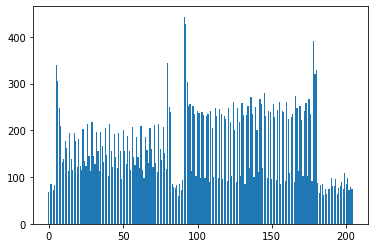

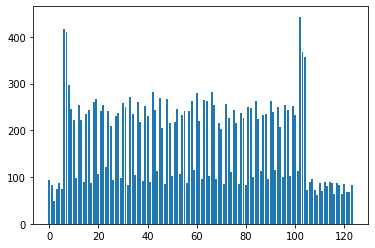

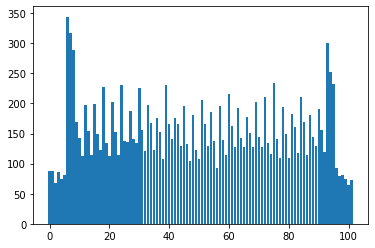

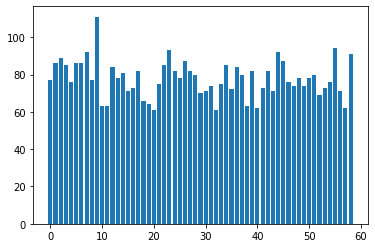

In [9]:
# both
plt.bar(np.arange(len(observed_data[2])), observed_data[2])
plt.show()
# only main coding region
plt.bar(np.arange(len(observed_data[0])), observed_data[0])
plt.show()
# only uORF
plt.bar(np.arange(len(observed_data[5])), observed_data[5])
plt.show()
# none
plt.bar(np.arange(len(observed_data[1])), observed_data[1])
plt.show()

# Run EM algorithm

In [10]:
# multiple initial values
trans_prob = [{'AUG': [0.2, 0.1, 0.3]}, {'AUG': [0.5, 0.2, 0.7]}, {'AUG': [0.8, 0.15, 0.1]}, {'AUG': [0.42, 0.42, 0.5]}]
alpha_list_prob = [np.array([10, 50, 40, 30, 30, 20, 10, 40 , 30, 20, 10, 80, 70, 60, 50, 40 , 30, 60, 50 , 40 , 10]),
            np.array([20, 100, 95, 90, 60, 40, 20, 70 , 66, 50, 10, 200, 180, 150, 100, 90 , 80, 180, 160 , 120 , 10]),
            np.array([1, 150, 110, 90, 50, 30, 10, 100 , 75, 50, 10, 250, 225, 200,150, 100 , 50, 225, 200 , 175, 1])]
beta_list_prob = [beta_list_true+2, beta_list_true * 2]

In [11]:
# run EM algorithm
start_trans = []
start_alpha_list = []
start_beta_list = []

final_trans = []
final_alpha_list = []
final_beta_list = []

start = 0
count = 1
for end in range(100, 3001, 100):
    
    trans_prob_copy = trans_prob.copy()
    # randomly generate index for trans
    random.seed(end)
    index = random.choice(range(4))
    trans = trans_prob_copy[index]
    start_trans.append(trans)
    
    # randomly generate index for alpha_list
    random.seed(end+1)
    index = random.choice(range(3))
    alpha_list = alpha_list_prob[index]
    start_alpha_list.append(alpha_list)
    
    # randomly generate index for beta_list
    random.seed(end+2)
    index = random.choice(range(2))
    beta_list = beta_list_prob[index]
    start_beta_list.append(beta_list)
    
    # run EM algorithm
    trans_copy = trans.copy()
    alpha_list_copy = alpha_list.copy()
    beta_list_copy = beta_list.copy()
    
    # Here's the EM algorithm
    temp = EM_iter(RNA_data[start:end], observed_data[start:end], E[start:end], trans_copy, alpha_list_copy, 
                   beta_list_copy, 10e-10, 100, False, ['UAA', 'UGA', 'UAG'], True)
    final_trans.append(temp[0])
    final_alpha_list.append(temp[1])
    final_beta_list.append(temp[2])
    
    start = end
    
    count += 1

In [12]:
# alpha and beta names
alpha_name_list = []
for i in range(1, 22):
    alpha_name_list.append(str(i))
    
beta_name_list = []
for i in range(1, 22):
    beta_name_list.append(str(i))

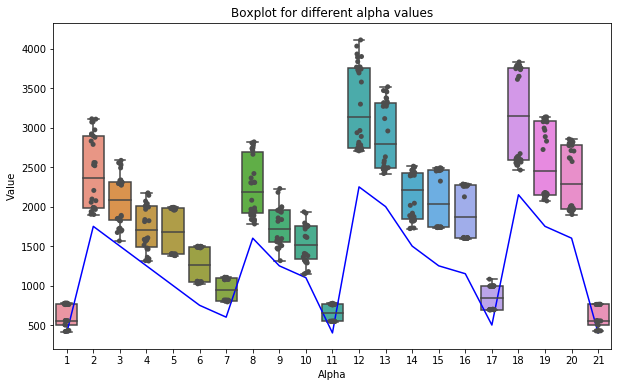

In [13]:
# construct final alpha dataframe
final_alpha_df = pd.DataFrame(final_alpha_list, columns=alpha_name_list)

fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(data=final_alpha_df)
sns.stripplot(data=final_alpha_df, color=".3", size=5)
locs=ax.get_xticks()
ax.plot(locs, alpha_list_true, 'b-')

# label
plt.xlabel('Alpha')
plt.ylabel('Value')
plt.title('Boxplot for different alpha values') 
fig.savefig("Boxplot for different alpha values")   

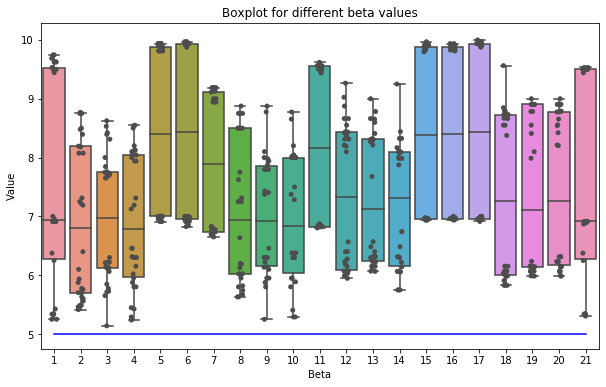

In [14]:
# construct final beta dataframe
final_beta_df = pd.DataFrame(final_beta_list, columns=beta_name_list)

fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(data=final_beta_df)
sns.stripplot(data=final_beta_df, color=".3", size=5)
locs=ax.get_xticks()
ax.plot(locs, beta_list_true, 'b-')

# label
plt.xlabel('Beta')
plt.ylabel('Value')
plt.title('Boxplot for different beta values') 
fig.savefig("Boxplot for different beta values")

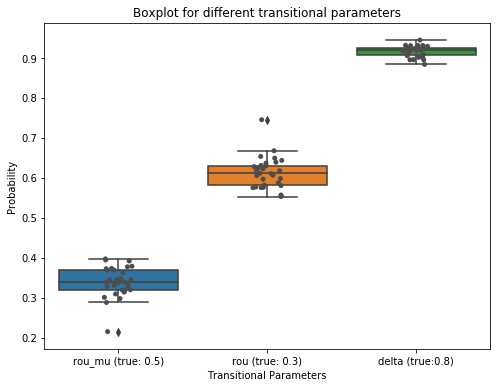

In [15]:
# boxplot of rou_mu (state 1 to state 2), rou (state 1 to state 12), delta (state 11 to state 12) for different start codons
rou_mu = []
rou = []
delta = []
for element in final_trans:
    rou_mu.append(element['AUG'][0])
    rou.append(element['AUG'][1])
    delta.append(element['AUG'][2])

# construct dataframe
final_trans_df = pd.DataFrame({"rou_mu (true: 0.5)":rou_mu, "rou (true: 0.3)":rou,"delta (true:0.8)": delta}, 
                                         columns=['rou_mu (true: 0.5)', 'rou (true: 0.3)', 'delta (true:0.8)'])

fig, ax = plt.subplots(figsize = (8, 6))
sns.boxplot(data=final_trans_df)
sns.stripplot(data=final_trans_df, color=".3", size=5)


plt.xlabel('Transitional Parameters')
plt.ylabel('Probability')
plt.title('Boxplot for different transitional parameters') 
fig.savefig("Boxplot for different transitional parameters")

# Run Viterbi algorithm

In [16]:
# calculate number of different number of states
def differ_state(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, state_list_true, model1):
    start = 0
    differ_list = []
    
    for end in range(100, 3001, 100):
        count = 0
        # run viterbi algorithm
        viterbi_output = viterbi_sequence(RNA_data[start:end], observed_data[start:end], 
                                          alpha_list[int(start/100)], beta_list[int(start/100)], 
                                          E[start:end], trans[int(start/100)], stop_codon_list, model1) 
        # true state
        curr_state = state_list_true[start:end]
        # count difference
        for i in range(len(curr_state)):
            for j in range(len(curr_state[i])):
                if viterbi_output[i][j] != curr_state[i][j]:
                    count += 1
        
        differ_list.append(count)
        start += 100
    
    return differ_list

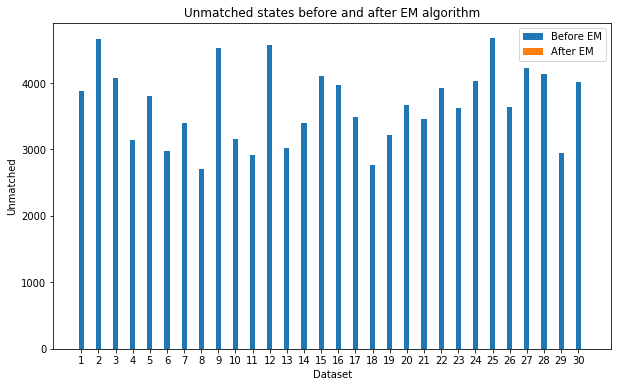

In [17]:
# before and after EM algorithm
before = differ_state(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, state_list_true, True)
after = differ_state(RNA_data, observed_data, final_alpha_list, final_beta_list, E, final_trans, stop_codon_list, state_list_true, True)

# plot
fig, ax = plt.subplots(figsize = (10,6))
plt.xticks(np.arange(1, 31, 1))
ind = np.arange(1, 31, 1)
width = 0.3

# label
plt.bar(ind, before, width, label = 'Before EM')
plt.bar(ind + width, after, width, label = 'After EM') 
plt.xlabel('Dataset')
plt.ylabel('Unmatched')
plt.title('Unmatched states before and after EM algorithm') 
plt.legend(loc = 'best')
fig.savefig("Unmatched states before and after EM algorithm")

In [18]:
# percentage of start codons
def percent(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, viterbi_truth, state_list_true, specific_codon, model1):

    start = 0
    output_list = []
    output_codon_num = []
    
    for end in range(100, 3000, 100): 
        
        if viterbi_truth == True:
            viterbi_output = viterbi_sequence(RNA_data[start:end], observed_data[start:end], 
                                          alpha_list[int(start/100)], beta_list[int(start/100)], 
                                          E[start:end], trans[int(start/100)], stop_codon_list, model1)  
        else:
            viterbi_output = state_list_true[start:end]
        
        
        codon_num_list = []
        actual_start_list = []
        for sequence_num in range(len(viterbi_output)):
            start_codon = 0
            actual_start = 0
            
            # find states for start and end
            starts = [j for j, x in enumerate(viterbi_output[sequence_num]) if x == 10]
            ends = [j for j, x in enumerate(viterbi_output[sequence_num]) if x == 2]
            
            # actual number of start codons
            for position in ends:
                if RNA_data[start+sequence_num][position] == specific_codon[0]:
                    actual_start += 1
            actual_start_list.append(actual_start)
            
            starts.insert(0, -1)

            if len(ends) == 0:
                ends.append(len(viterbi_output[sequence_num]) - 4)
                
            pairs = []
            for i in range(len(ends)):
                pairs.append((starts[i]+1, ends[i]))

            # total number of start codons
            for pair in pairs:
                for i in range(pair[0], pair[1]+1):
                    codon = RNA_data[start+sequence_num][i] + RNA_data[start+sequence_num][i+1] + RNA_data[start+sequence_num][i+2]
                    if codon == specific_codon: 
                        start_codon += 1
            codon_num_list.append(start_codon)
        
        # total num of codons for each dataset
        output_codon_num.append(sum(codon_num_list))
        
        # percentage
        output_list.append(sum(actual_start_list)/ sum(codon_num_list)) 
       
        start += 100 
    
    return output_list

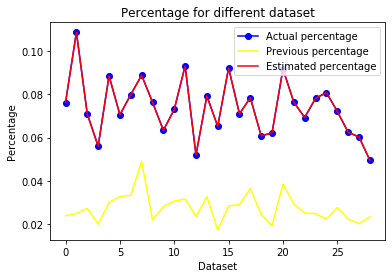

In [19]:
actual_percentage_AUG = percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, False, state_list_true, 'AUG', True)
previous_percentage_AUG = percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, True, state_list_true, 'AUG', True)
estimated_percentage_AUG = percent(RNA_data, observed_data, final_alpha_list, final_beta_list, E, final_trans, stop_codon_list, True, state_list_true, 'AUG', True)

fig, ax = plt.subplots(figsize = (6,4))
plt.plot(actual_percentage_AUG, color = 'blue', marker = 'o', label = 'Actual percentage')
plt.plot(previous_percentage_AUG, color = 'yellow', label = 'Previous percentage')
plt.plot(estimated_percentage_AUG, color = 'red', label = 'Estimated percentage')
plt.legend()
plt.title('Percentage for different dataset')
plt.xlabel('Dataset')
plt.ylabel('Percentage')
plt.show()
fig.savefig("Percentage for different dataset")

# Beta fixed

In [20]:
# multiple initial values
trans_prob = [{'AUG': [0.2, 0.1, 0.3]}, {'AUG': [0.5, 0.2, 0.7]}, {'AUG': [0.8, 0.15, 0.1]}, {'AUG': [0.42, 0.42, 0.5]}]
alpha_list_prob = [np.array([10, 50, 40, 30, 30, 20, 10, 40 , 30, 20, 10, 80, 70, 60, 50, 40 , 30, 60, 50 , 40 , 10]),
            np.array([20, 100, 95, 90, 60, 40, 20, 70 , 66, 50, 10, 200, 180, 150, 100, 90 , 80, 180, 160 , 120 , 10]),
            np.array([1, 150, 110, 90, 50, 30, 10, 100 , 75, 50, 10, 250, 225, 200,150, 100 , 50, 225, 200 , 175, 1])]

In [21]:
final_trans_beta_fixed = []
final_alpha_list_beta_fixed = []

start_trans_beta_fixed = []
start_alpha_list_beta_fixed = []

start = 0
count = 1
for end in range(100, 3001, 100):
    
    trans_prob_copy = trans_prob.copy()
    # randomly generate index for trans
    random.seed(end)
    index = random.choice(range(4))
    trans = trans_prob_copy[index]
    start_trans_beta_fixed.append(trans)
    
    # randomly generate index for alpha_list
    random.seed(end+1)
    index = random.choice(range(3))
    alpha_list = alpha_list_prob[index]
    start_alpha_list_beta_fixed.append(alpha_list)
    
    # run EM algorithm
    trans_copy = trans.copy()
    alpha_list_copy = alpha_list.copy()
    
    temp = EM_iter(RNA_data[start:end], observed_data[start:end], E[start:end], trans_copy, alpha_list_copy, 
                   beta_list_true, 10e-10, 100, True, ['UAA', 'UGA', 'UAG'], True)
    final_trans_beta_fixed.append(temp[0])
    final_alpha_list_beta_fixed.append(temp[1])
    
    start = end
    
    count += 1

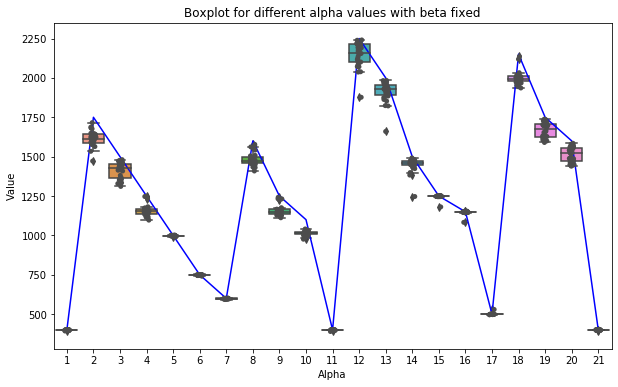

In [22]:
alpha_name_list = []
for i in range(1, 22):
    alpha_name_list.append(str(i))
    

final_alpha_df_beta_fixed = pd.DataFrame(final_alpha_list_beta_fixed, columns=alpha_name_list)


fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(data=final_alpha_df_beta_fixed)
sns.stripplot(data=final_alpha_df_beta_fixed, color = '.3', size = 5)
locs=ax.get_xticks()
ax.plot(locs, alpha_list_true, 'b-')

plt.xlabel('Alpha')
plt.ylabel('Value')
plt.title('Boxplot for different alpha values with beta fixed') 
fig.savefig("Boxplot for different alpha values with beta fixed")

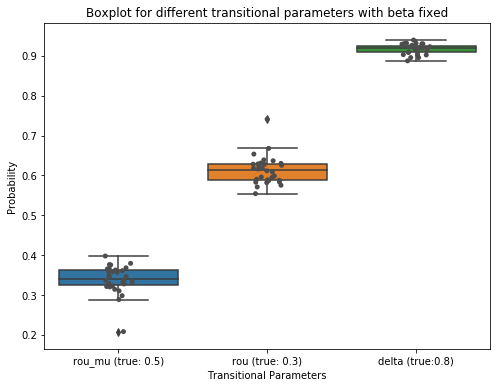

In [23]:
# boxplot of rou_mu (state 1 to state 2), rou (state 1 to state 12), delta (state 11 to state 12) for different start codons
rou_mu_beta_fixed = []
rou_beta_fixed = []
delta_beta_fixed = []
for element in final_trans_beta_fixed:
    rou_mu_beta_fixed.append(element['AUG'][0])
    rou_beta_fixed.append(element['AUG'][1])
    delta_beta_fixed.append(element['AUG'][2])

# construct dataframe
final_trans_df_beta_fixed = pd.DataFrame({"rou_mu (true: 0.5)":rou_mu_beta_fixed, "rou (true: 0.3)":rou_beta_fixed,"delta (true:0.8)": delta_beta_fixed}, 
                                         columns=['rou_mu (true: 0.5)', 'rou (true: 0.3)', 'delta (true:0.8)'])

fig, ax = plt.subplots(figsize = (8, 6))
sns.boxplot(data=final_trans_df_beta_fixed)
sns.stripplot(data=final_trans_df_beta_fixed, color=".3", size=5)


plt.xlabel('Transitional Parameters')
plt.ylabel('Probability')
plt.title('Boxplot for different transitional parameters with beta fixed') 
fig.savefig("Boxplot for different transitional parameters with beta fixed")

# Run Viterbi algorithm

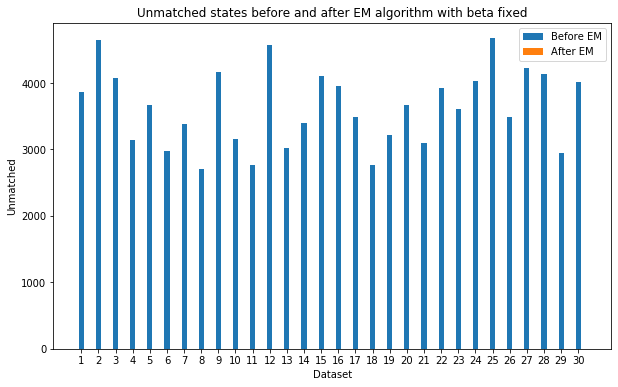

In [24]:
beta_list_beta_fixed = np.repeat([beta_list_true],30, axis = 1).reshape(30,21)

# before and after EM algorithm with beta fixed
before_beta_fixed = differ_state(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, 
                                 E, start_trans_beta_fixed, stop_codon_list, state_list_true, True)
after_beta_fixed = differ_state(RNA_data, observed_data, final_alpha_list_beta_fixed, beta_list_beta_fixed, 
                                E, final_trans_beta_fixed, stop_codon_list, state_list_true, True)

# plot with beta fixed
fig, ax = plt.subplots(figsize = (10,6))
plt.xticks(np.arange(1, 31, 1))
ind = np.arange(1, 31, 1)
width = 0.3

# label
plt.bar(ind, before_beta_fixed, width, label = 'Before EM')
plt.bar(ind + width, after_beta_fixed, width, label = 'After EM') 
plt.xlabel('Dataset')
plt.ylabel('Unmatched')
plt.title('Unmatched states before and after EM algorithm with beta fixed') 
plt.legend(loc = 'best')
fig.savefig("Unmatched states before and after EM algorithm with beta fixed")

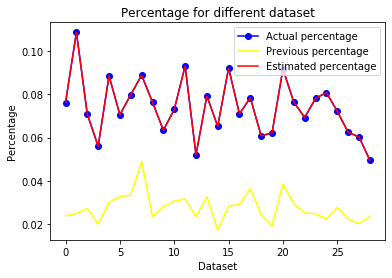

In [25]:
actual_percentage_AUG_beta_fixed = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, 
                                           E, start_trans_beta_fixed, stop_codon_list, False, state_list_true, 'AUG', True)
previous_percentage_AUG_beta_fixed = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, 
                                             E, start_trans_beta_fixed, stop_codon_list, True, state_list_true, 'AUG', True)
estimated_percentage_AUG_beta_fixed = percent(RNA_data, observed_data, final_alpha_list_beta_fixed, beta_list_beta_fixed, 
                                              E, final_trans_beta_fixed, stop_codon_list, True, state_list_true, 'AUG', True)

fig, ax = plt.subplots(figsize = (6,4))
plt.plot(actual_percentage_AUG_beta_fixed, color = 'blue', marker = 'o', label = 'Actual percentage')
plt.plot(previous_percentage_AUG_beta_fixed, color = 'yellow', label = 'Previous percentage')
plt.plot(estimated_percentage_AUG_beta_fixed, color = 'red', label = 'Estimated percentage')
plt.legend()
plt.title('Percentage for different dataset')
plt.xlabel('Dataset')
plt.ylabel('Percentage')
plt.show()
fig.savefig("Percentage for different dataset")